## 기계학습(8585) - 기말고사 대체 과제
### 제품 review 데이터의 감성 분석 

<div style="text-align: right"> 201920879 김태현 </div>

---

### 프로젝트 개요:

학생들은 텍스트 데이터를 감성으로 분류하는 감성 분석 시스템을 개발합니다. 이 프로젝트는 전처리, 모델 선택, 학습, 평가 및 결과 시각화를 포함합니다.

### 프로젝트 목표(보고서 목차):

1. **감성 분석의 기본 이해**: 감성 분석이 무엇이며 그 응용에 대해 학습
2. **데이터 전처리**: 머신 러닝 작업을 위해 데이터 전처리하는 경험을 쌓음
3. **모델 선택 및 학습**: 수업에서 활용한 모델을 활용해서 구현하고 그 강점과 약점을 이해
4. **평가**: 적절한 지표를 사용하여 모델의 성능을 평가
5. **시각화 및 해석**: 결과를 시각화하고 해석

### 프로젝트 구성 요소:

1. 데이터:
    - `amazon_uk_shoes_products_dataset_2021_12.csv` 데이터 분석
2. 데이터 전처리:
    - 데이터 정리(노이즈 제거, 결측값 처리 등)
    - 텍스트 토큰화 및 불용어 제거
    - 텍스트 정규화(스테밍 또는 표제어 추출)
3. 모델 구현:
    - 수업에서 활용한 모델을 적용
4. 모델 학습 및 튜닝:
    - 데이터셋을 학습 및 테스트 세트로 분할.
    - 모델 학습 및 하이퍼파라미터 튜닝 (예: 그리드 서치 또는 랜덤 서치 사용)
    - 교차 검증과 같은 기술을 사용하여 견고성 보장.
5. *모델 평가:
    - 정확도, 정밀도, 재현률, F1 점수 및 ROC-AUC와 같은 지표를 사용하여 모델 평가.
    - 오버피팅과 언더피팅을 논의하고 이를 해결하는 방법 학습.
6. 시각화 및 보고:
    - Matplotlib 또는 Seaborn과 같은 라이브러리를 사용하여 결과 시각화
    - 혼동 행렬 및 ROC 곡선 생성
    - 보고서에 결과 요약.


### 0. 환경 구성
---
- 감성 분석에 필요한 모듈을 설치하고 적용

In [70]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정
import matplotlib.font_manager as fm
font_path = './fonts/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'

# 현재 작업 경로 확인
current_directory = os.getcwd()
print(current_directory)

c:\Users\taehyun\github-classroom\Konkuk-Univ-Glocal-Campus\ml202401-final-taehyunkim32


### 1. 데이터를 읽고 데이터 구조를 확인
---
- `amazon_uk_shoes_products_dataset_2021_12.csv`를 pandas로 읽어와 데이터 프레임으로 저장

- 총 리뷰 데이터의 개수는 6823개
- 총 11개의 열이 존재

In [71]:
raw_df = pd.read_csv("./amazon_uk_shoes_products_dataset_2021_12.csv")
print(f"* 총 리뷰 개수: {raw_df.shape[0]} *")
print(raw_df.info())

* 총 리뷰 개수: 6823 *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6823 entries, 0 to 6822
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                6823 non-null   object 
 1   product_name       6823 non-null   object 
 2   reviewer_name      6823 non-null   object 
 3   review_title       6822 non-null   object 
 4   review_text        6814 non-null   object 
 5   review_rating      6823 non-null   float64
 6   verified_purchase  6823 non-null   bool   
 7   review_date        6823 non-null   object 
 8   helpful_count      1953 non-null   object 
 9   uniq_id            6823 non-null   object 
 10  scraped_at         6823 non-null   object 
dtypes: bool(1), float64(1), object(9)
memory usage: 539.8+ KB
None


- 실제 데이터 정보 확인
- 열에 대한 정보
    1. url: 상품의 링크
    2. product_name: 상품의 이름
    3. reviewer_name: 리뷰 작성자의 이름
    4. review_title: 리뷰의 제목
    5. review_text: 리뷰의 내용
    6. review_rating: 리뷰의 별점
    7. verified_purchase: 실제 구매 여부
    8. review_date: 리뷰 작성일
    9. helpful_count: 리뷰에 대한 평가 정보
    10. uniq_id: 리뷰의 고유 아이디
    11. scraped_at: 리뷰 등록일

In [72]:
# 첫 번째 행의 열 이름과 값을 출력
for column in raw_df.columns:
    print(f"{column} : {raw_df.iloc[0][column]}")

url : https://www.amazon.co.uk/dp/B07SBX32T5
product_name : Klasified Women's Transparent Clear Sneaker Shoe, White, 5.5 UK
reviewer_name : Jocelyn McSayles
review_title : Love em
review_text : Love these. Was looking for converses and these were half the price and so unique— I’ve never seen clear shoes like these; they fit great. The plastic takes a little getting used to but the style is so worth it.
review_rating : 5.0
verified_purchase : True
review_date : Reviewed in the United States on 2 June 2020
helpful_count : 2 people found this helpful
uniq_id : 36eae4e5-2894-5279-a0b7-d2b330e2b814
scraped_at : 24/12/2021 02:26:25


### 2. 데이터 전처리
---
- 모델 성능 향상을 위해 데이터 전처리를 통해 테이터를 정제화시키는 과정이 필요
1) `중복 데이터 제거`: 데이터셋 내 중복된 항목들을 식별하고 제거하여 데이터의 정확성 향상
2) `주요 특성 설정`: 분석에 중요한 특성(컬럼)을 선택하여 데이터셋을 간소화
3) `결측치 확인 및 제거`: 누락된 값이 있는 행 처리
4) `노이즈 제거`: 불필요한 단어(숫자, 다중 공백, 특수 문자 등)을 제거, 텍스트 소문자로 변경
5) `토큰화`: 텍스트 데이터를 단어 단위로 토큰화
6) `불용어 제거`: 분석에 불필요한 단어 제거(Ex: 'is', "the', 'and' 등)
7) `표제어 추출`: 단어의 기본 형태(표제어)로 변환(Ex: 'running', 'ran', 'runs' → 'run')

1) `중복 데이터 제거`

- 총 리뷰 데이터의 개수는 6823개
- uniq_id열 기준으로 중복된 행의 개수가 364개
- 예시로 1002번 인덱스의 리뷰 데이터와 1828번 인덱스의 리뷰 데이터가 같은 것을 확인

In [73]:
# uniq_id 열을 기준으로 중복된 행 확인
dup = raw_df.duplicated(subset=['uniq_id'], keep=False)

# 중복된 행의 개수
count_dup = dup.sum()
print(f"중복된 행의 개수: {count_dup}")

# 중복된 uniq_id 예시 추출
dup_uniq_id = raw_df['uniq_id'][raw_df['uniq_id'].duplicated()].iloc[0]

# 중복된 uniq_id 출력
print(f"중복된 uniq_id: {dup_uniq_id}")

# 중복 리뷰 케이스 확인
selected_columns = ['review_title', 'review_text', 'review_rating', 'uniq_id']
filtered_rows = raw_df[raw_df['uniq_id'] == dup_uniq_id][selected_columns]

# 결과 출력
filtered_rows

중복된 행의 개수: 364
중복된 uniq_id: d1871977-2e70-5d3d-bcb9-888819c4d0d6


,review_title,review_text,review_rating,uniq_id
1002,Per ben due volte taglia errata,Per ben due volte ho dovuto restituire l'artic...,1.0,d1871977-2e70-5d3d-bcb9-888819c4d0d6
1828,Per ben due volte taglia errata,Per ben due volte ho dovuto restituire l'artic...,1.0,d1871977-2e70-5d3d-bcb9-888819c4d0d6


- uniq_id 열을 기준으로 첫 번째 행만 유지, 나머지 행 삭제
  1. 원본 데이터: 6823
  2. 중복 데이터: 364
  3. 중복 데이터를 제외한 데이터: 6823 - (364 / 2) = 6641

In [74]:
# uniq_id 열을 기준으로 중복된 행 제거
df_unique = raw_df.drop_duplicates(subset=['uniq_id'], keep='first')

# 중복이 제거된 총 리뷰의 개수
count_unique = len(df_unique)
print(f"중복 데이터를 제외한 행의 개수: {count_unique}")

중복 데이터를 제외한 행의 개수: 6641


2) `주요 특성 설정`

- 11개의 열 중에 감성 분석에 사용할 열을 선택
- `review_title`, `review_text`, `review_rating` 3가지 칼럼을 주요 특성으로 사용
  1. `review_title`: 리뷰의 핵심 내용을 요약하여 감성 분석에 중요한 단서
  2. `review_text`: 리뷰의 상세 내용을 포함하고 있어 감성 분석을 위한 정보
  3. `review_rating`: 감성 분석 결과에 대해 맞게 분석이 되었는지 확인할 수 있는 지표

In [75]:
# 사용할 columns 선택
df_selected = df_unique[["review_title", "review_text", "review_rating"]]
df_selected.head(5)

,review_title,review_text,review_rating
0,Love em,Love these. Was looking for converses and thes...,5.0
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,Good quality,5.0
3,Good,Great,5.0
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0


3) `결측치 확인 및 제거`

- 결측치를 확인하기 위해 isnull()과 sum()을 사용하여 결측 값의 개수를 확인
  1. `제목 결측치`: 1개의 결측치 발견
  2. `리뷰 결측치`: 8개의 결측치 발견
  3. `레이팅 결측치`: 0개의 결측치 발견

In [76]:
print(f"제목 결측치 개수: {df_selected['review_title'].isnull().sum()}")
print(f"리뷰 결측치 개수: {df_selected['review_text'].isnull().sum()}")
print(f"레이팅 결측치 개수: {df_selected['review_rating'].isnull().sum()}")

제목 결측치 개수: 1
리뷰 결측치 개수: 8
레이팅 결측치 개수: 0


- 제목, 리뷰에 결측치가 존재하는 행은 제거
    1. 중복 데이터를 제외한 데이터: 6641
    2. 결측치가 존재하는 데이터 : 1 + 8 = 9
    3. 결측치를 제외한 데이터: 6641 - 9 = 6632

In [78]:
df_cleaned = df_selected.dropna(subset=["review_text", "review_title"])

# 결측치가 제거된 총 리뷰의 개수
count_cleand = len(df_cleaned)
print(f"결측치를 제외한 행의 개수: {count_cleand}")

결측치를 제외한 행의 개수: 6632


,review_title,review_text,review_rating
0,Love em,Love these. Was looking for converses and thes...,5.0
1,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Good quality,Good quality,5.0
3,Good,Great,5.0
4,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0


4) `노이즈 제거`: 불필요한 단어(숫자, 다중 공백, 특수 문자 등)을 제거, 텍스트 소문자로 변경
5) `토큰화`: 텍스트 데이터를 단어 단위로 토큰화
6) `불용어 제거`: 분석에 불필요한 단어 제거(Ex: 'is', "the', 'and' 등)
7) `표제어 추출`: 단어의 기본 형태(표제어)로 변환(Ex: 'running', 'ran', 'runs' → 'run')

- `노이즈 제거`, `토큰화`, `불용어 제거`, `표제어 추출`을 위한 전처리 함수 선언
- `review_text`열과 `review_title`열에 전처리 함수 적용

In [130]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# 필요한 NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# 전처리 함수 선언
def data_preprocessing(contents):
    # 노이즈 제거 (소문자로 변환, 숫자 제거, 다중 공백 제거, 특수 문자 제거)
    contents = re.sub(r'[^\w\s]', '', re.sub(r'\s+', ' ', re.sub(r'\d+', '', contents.lower())))

    # 토큰화
    tokens = word_tokenize(contents)
    
    # 불용어 제거
    stopword = [word for word in tokens if word not in stopwords.words("english")]
    
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopword]
    
    return ' '.join(tokens)

# 텍스트 전처리
df_cleaned["review_title"] = df_cleaned["review_title"].apply(data_preprocessing)
df_cleaned["review_text"] = df_cleaned["review_text"].apply(data_preprocessing)

# 전처리 완료
df = df_cleaned

df.head(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,review_title,review_text,review_rating,title_compound,text_compound,Sentiment_Score,label,total
0,love em,love looking converse half price unique ive ne...,5.0,0.6369,0.9188,0.77785,1,love em love looking converse half price uniqu...
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.0000,0.2240,0.11200,1,plastic ripped shoe cute nd day wearing tongue...
2,good quality,good quality,5.0,0.4404,0.4404,0.44040,1,good quality good quality
3,good,great,5.0,0.4404,0.6249,0.53265,1,good great
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,0.0000,-0.4588,-0.22940,0,perfette ho scelto il modello bianco con rifin...


### 3. 모델 구현
---
- 수업 시간에 배운 VADER 감성 분석기를 활용하여 감성 점수를 계산하고 해당 리뷰가 긍정적인지 부정적인지 확인
1) NLTK의 VADER 감성 분석기를 초기화하고 감성 점수를 계산하여 반환하는 함수 선언
2) `review_title`과 `review_text`에 대해 감성 계산을 진행
3) 각 점수는 데이터 프레임에 `title_compound`와 `text_compound`로 저장
4) `title_compound`와 `text_compound`의 평균을 리뷰의 최종 vader score인 `Sentiment_Score`로 저장
5) `Sentiment_Score`의 값이 0보다 크거나 같으면 1(긍정), 아니라면 0(부정)으로 라벨 분류
6) 감성 분석 결과 확인

In [87]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK 패키지 다운로드
nltk.download("vader_lexicon")

# VADER 감성 분석기 초기화
vader_sentiment = SentimentIntensityAnalyzer()

# 감성 계산 함수 선언
def calc_sentiment(review): 
    # VADER 감성 분석기를 사용하여 'compound' 스코어를 반환
    return vader_sentiment.polarity_scores(review)["compound"]

# 감성 점수 계산 및 데이터 프레임에 추가
# review_title과 review_text에 calc_sentiment 함수를 적용 후 결과를 df에 추가
df["title_compound"] = df.review_title.apply(calc_sentiment)
df["text_compound"] = df.review_text.apply(calc_sentiment)

df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\taehyun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review_title,review_text,review_rating,title_compound,text_compound
0,love em,love looking converse half price unique ive ne...,5.0,0.6369,0.9188
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.0000,0.2240
2,good quality,good quality,5.0,0.4404,0.4404
3,good,great,5.0,0.4404,0.6249
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,0.0000,-0.4588
...,...,...,...,...,...
6818,schick und leicht,schicker schuh läuft sich gut,5.0,0.0000,0.0000
6819,excellent,mieux que je ne limaginais très bonne taille b...,5.0,0.5719,0.0000
6820,einfach schöne hausschuhe,habe sie al geschenk gekauft und sie sind sehr...,5.0,0.0000,0.5994
6821,langlebig,trage diese hausschuhe fast zwei monate jeden ...,5.0,0.0000,-0.7845


In [88]:
# title_compound와 text_compound의 평균을 계산하여 Sentiment_Score 칼럼에 추가
df["Sentiment_Score"] = (df["title_compound"] + df["text_compound"]) / 2

df[["review_title", "review_text", "review_rating", "Sentiment_Score"]].head(10)

,review_title,review_text,review_rating,Sentiment_Score
0,love em,love looking converse half price unique ive ne...,5.0,0.77785
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.11200
2,good quality,good quality,5.0,0.44040
3,good,great,5.0,0.53265
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,-0.22940
5,delusione,sono solita comprare scarpe guess e non ho mai...,1.0,0.00000
6,molto belle,le scarpe sono molto belle calzano perfettamente,5.0,0.00000
7,molto carine e comode,semplicemente perfette io uso plantari su misu...,5.0,0.00000
8,bellissimepeccato per il numero,le scarpe sono bellissime arrivate perfetto st...,5.0,0.00000
9,scarpe ben realizzate venditore ottimo,le scarpe sono ben fatte e il venditore molto ...,5.0,0.17000


- `Sentiment_Score`는 -1에서 1까지 인것을 확인 가능
- `Sentiment_Score`의 최저점은 -0.8726, 최고점은 0.9602

In [134]:
# 최저 Sentiment_Score
min_score = df['Sentiment_Score'].min()
print(f"최저점: {min_score:.4f}")

# 최고 Sentiment_Score
max_score = df['Sentiment_Score'].max()
print(f"최고점: {max_score:.4f}")

최저점: -0.8726
최고점: 0.9602


- `Sentiment_Score`가 0이상일 경우 1(긍정), 아닐 경우 0(부정)으로 라벨 분류

In [102]:
# Sentiment_Score 점수를 기준으로 감성 레이블 생성 (긍정 1, 부정 0)
def sentiment_label(score):
    if score >= 0:
        return 1
    else:
        return 0

df["label"] = df["Sentiment_Score"].apply(sentiment_label)

df[["review_title", "review_text", "review_rating", "Sentiment_Score", "label"]].head(10)

,review_title,review_text,review_rating,Sentiment_Score,label
0,love em,love looking converse half price unique ive ne...,5.0,0.77785,1
1,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,0.11200,1
2,good quality,good quality,5.0,0.44040,1
3,good,great,5.0,0.53265,1
4,perfette,ho scelto il modello bianco con rifinitura die...,5.0,-0.22940,0
5,delusione,sono solita comprare scarpe guess e non ho mai...,1.0,0.00000,1
6,molto belle,le scarpe sono molto belle calzano perfettamente,5.0,0.00000,1
7,molto carine e comode,semplicemente perfette io uso plantari su misu...,5.0,0.00000,1
8,bellissimepeccato per il numero,le scarpe sono bellissime arrivate perfetto st...,5.0,0.00000,1
9,scarpe ben realizzate venditore ottimo,le scarpe sono ben fatte e il venditore molto ...,5.0,0.17000,1


- `review_rating`이 3점이상인 경우에는 대부분 올바르게 처리
- `review_rating`이 2점이하인 경우에는 대부분 올바르지 못하게 처리
- 더 자세히 감성 분석 결과에 대해 확인 필요

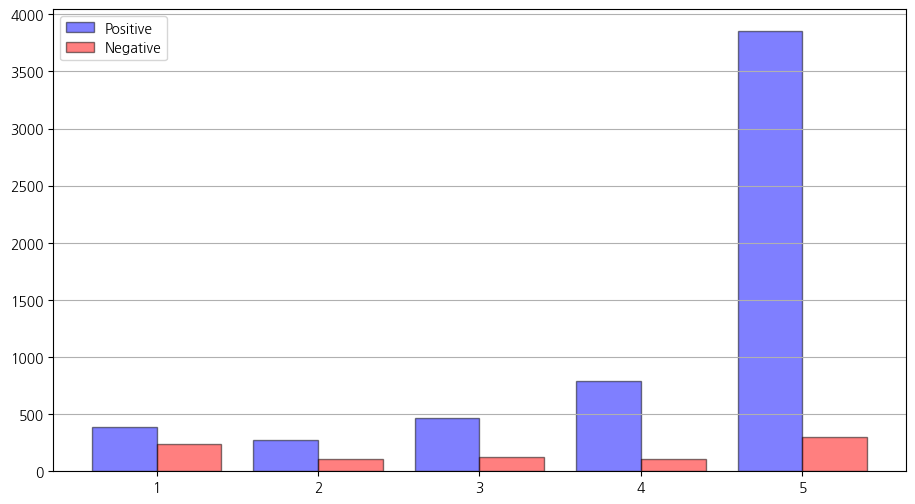

In [100]:
# 긍정, 부정 라벨 데이터 분리
positive = df[df['label'] == 1]['review_rating']
negative = df[df['label'] == 0]['review_rating']

# 히스토그램 설정
plt.figure(figsize=(11, 6))

plt.hist([positive, negative], bins=range(1, 7), label=["Positive", "Negative"], color=['blue', 'red'],alpha=0.5, edgecolor='black', align='left')
plt.legend(loc="upper left")
plt.grid(axis='y')

plt.show()

- `great` `kind` `super`와 같이 긍정적인 단어가 보인 리뷰에서는 높은 점수 획득

In [110]:
# Sentiment_Score 높은 순
df.sort_values(by='Sentiment_Score', ascending=False).head(5)

,review_title,review_text,review_rating,title_compound,text_compound,Sentiment_Score,label
5427,great shoe great price fit kind weird,great shoe little surprised got shoe noticed g...,4.0,0.9246,0.9957,0.96015,1
553,super comfortable stylish great quality easy c...,wider foot fit great super comfortable easy wa...,5.0,0.9509,0.9618,0.95635,1
2320,love love love,usually wear based review ordered half size sm...,5.0,0.9274,0.9831,0.95525,1
3900,comfortable great support awesome value,arrived speak durability yet im thrilled shoe ...,5.0,0.9485,0.9566,0.95255,1
5840,perfect fit amazing quality comfort,awesome highquality comfortable shoe cant say ...,5.0,0.9100,0.9914,0.95070,1


- `die`와 같이 부정적인 단어가 보인 리뷰에서는 낮은 점수 획득

- *다만, 리뷰가 영어로 적혀있지 않은 것으로 보이나 영어로 판독하여 부정적인 결과가 나온 리뷰들도 있는 것으로 보입니다.*

In [111]:
# Sentiment_Score 낮은 순
df.sort_values(by='Sentiment_Score').head(5)

,review_title,review_text,review_rating,title_compound,text_compound,Sentiment_Score,label
5263,die bequemsten schuhe die ich jemals getragen ...,auf der suche nach bequemen sneakern sind mir ...,5.0,-0.8316,-0.9136,-0.87260,0
2103,die qualität hat extrem nachgelassen,ich habe zwei jacken bestellt farben limette u...,1.0,-0.5994,-0.9955,-0.79745,0
2108,nicht dicht vorsicht achtet drauf wer die stie...,wir sind sehr enttäuscht die stiefel x angehab...,1.0,-0.5994,-0.9661,-0.78275,0
2961,die dicke sohle ist sehr gelenkfreundlich mein...,ich habe mir gedacht das diese schuhe eine gut...,5.0,-0.5994,-0.9601,-0.77975,0
4993,endlich ein idealer winterschuh auch für frau ...,al berufspendler der täglich lange zeit mit öf...,4.0,-0.5994,-0.9565,-0.77795,0


- 정확한 분석은 5450개
- 비정확한 분석은 1182개
- 약 80퍼센트의 정확성
- *잘못 예측될만한 상황이 있음에도 불구하고 생각보다 높은 정확성을 보입니다.*

In [142]:
# Sentiment_Score와 review_rating 매칭 함수 선언
good = 0
bad = 0

for i in range(len(df)):
    if (df.iloc[i, 2] >= 3.0 and df.iloc[i, 6] == 1) or (df.iloc[i, 2] < 3.0 and df.iloc[i, 6] == 0):
        good += 1
    else:
        bad += 1

# 결과 출력
print("정확한 분석: ", good)
print("비정확한 분석: ", bad)

accuracy = good / (good + bad)
print(f"분석 정확성: {accuracy:.4f}")


정확한 분석:  5450
비정확한 분석:  1182
분석 정확성: 0.8218


### 4. 모델 학습 및 튜닝
---
- 학습 모델은 로지스틱 회귀 모델을 사용
1) 학습에 사용될 데이터(`review_title`, `review_text`)를 TF-IDF 벡터화
2) 로지스틱 회귀 모델 학습 및 평가에 사용될 데이터셋을 8:2로 분할
3) 하이퍼파라미터 튜닝 기법으로는 그리드 서치를 사용
4) `C`와 `max_iter`에 대한 하이퍼파라미터 튜닝
5) 교차 검증을 위한 fold 횟수는 5회로 지정

In [118]:
# 필요한 sklearn 패키지 설치
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

- `review_title`과 `review_text` 칼럼을 하나의 칼럼으로 합친 후 TF_IDF 백터화 진행
- TF-IDF 벡터화는 문자열 리스트를 학습을 위해 벡터로 바꿔주는 작업
- 로지스틱 회귀 모델 학습 및 평가를 위해 데이터셋 분할
- 학습 데이터와 평가 데이터는 8:2 비율로 분할

In [115]:
# y값 지정
y = df["label"]

# 제목과 리뷰 내용을 합치기
df["total"] = df["review_title"] + " " + df["review_text"]

# TF-IDF 백터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["total"])

# 학습 데이터와 테스트 데이터로 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- 로지스틱 회귀 모델 사용을 위한 초기화
- 하이퍼마라미터 그리드 설정
- cv = 5는 k-fold 교차 검증을 사용하여 데이터를 5개 부분으로 나누어 검증
- 최적 파라미터 확인

In [116]:
# 로지스틱 회귀 모델 초기화
model = LogisticRegression()

# 하이퍼파라미터 그리드 설정
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "max_iter": [100, 1000]
}

# 그리드 서치 객체 생성 (모델, 하이퍼파라미터, 교차 검증 횟수, 성능 평가 지표 설정)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy")

# 그리드 서치 실행 (훈련 데이터에 맞추어 모델 학습)
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터와 테스트 정확도 출력
print("최적 파라미터:", grid_search.best_params_)
print("테스트 정확도:", grid_search.score(X_test, y_test))

최적 파라미터: {'C': 10, 'max_iter': 100}
테스트 정확도: 0.9397136397889977


- 그리드 서치를 통해 알아낸 최적의 하이퍼파라미터 값은 C가 10, max_iter가 100
- 최적의 하이퍼파라미터 값으로 모델 학습

In [117]:
# 그리드 서치를 통해 찾은 최적의 모델
best_model = grid_search.best_estimator_

# 훈련 데이터를 사용하여 최적 모델 학습
best_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측값 생성
y_pred = best_model.predict(X_test)

### 5. 모델 평가
---
- 각 지표들을 활용하여 모델 평가 진행
- 평가 지표로는 정확도(accuracy), 정밀도(precision), 재현률(recall), F1 점수 및 ROC-AUC를 사용

1) `정확도(Accuracy)`: 전체 예측 중 올바르게 예측한 비율
2) `정밀도(Precision)`: 양성으로 예측한 것 중 실제 양성인 비율
3) `재현율(Recall)`: 실제 양성 중 양성으로 예측한 비율
4) `F1-score`: 정밀도와 재현율의 조화 평균
5) `ROC-AUC`: ROC 곡선 아래 면적, 클래스 구분 성능 평가, 1에 가까울수록 완벽한 구분 의미

In [121]:
# 정확도 평가
print(f"정확도: {accuracy_score(y_test, y_pred):.5f}")

# 정밀도 평가
print(f"정밀도: {precision_score(y_test, y_pred, average='weighted'):.5f}")

# 재현율 평가
print(f"재현율: {recall_score(y_test, y_pred, average='weighted'):.5f}")

# F1 점수 평가
print(f"F1-점수: {f1_score(y_test, y_pred, average='weighted'):.5f}")

# ROC-AUC 점수
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.5f}")

# 모델 성능 평가
print(classification_report(y_test, y_pred))

정확도: 0.93971
정밀도: 0.93817
재현율: 0.93971
F1-점수: 0.93455
ROC-AUC: 0.80030
              precision    recall  f1-score   support

           0       0.91      0.61      0.73       177
           1       0.94      0.99      0.97      1150

    accuracy                           0.94      1327
   macro avg       0.93      0.80      0.85      1327
weighted avg       0.94      0.94      0.93      1327



##### 모델 평가 결과:
- `정확도`: 93.97%로 매우 높다.
- `정밀도`와 `재현율`: 매우 높은 편으로 특히 클래스 1에 대해 매우 높은 재현율(0.99)을 보이고 있다.
- `F1-점수`: 93.45%로, 정밀도와 재현율 간의 균형이 잘 잡혀 있다.
- `ROC-AUC 점수`: 80%로, 클래스 구분 성능이 준수하다.
- `언더피팅(Underfitting)`: 현재 모델의 정확도와 F1-점수가 높은 것을 보아 언더피팅의 가능성은 낮다.
- `오버피팅(Overfitting)`: 현재 성능 평가 지표가 재현율뿐만 아니라 정밀도와 F1-점수도 높아서 전반적으로 모델이 균형 잡힌 성능이라고 볼 수 있다.
- `클래스 불균형 존재`: 클래스 0과 클래스 1의 데이터 수가 차이가 크다(177 vs 1150). 이로 인해 모델이 클래스 1에 대해 더 높은 성능을 보인다.

### 6. 시각화
---
- confusion_matrix(혼동 행렬)와 ROC 곡선을 활용하여 시각화

1) `confusion_matrix(혼동 행렬)`: 분류 모델의 성능을 평가하기 위해 사용되는 표, 실제 값과 예측 값을 비교하여 모델의 예측 능력을 시각화
2) `ROC 곡선`: 분류기의 성능을 평가하는 그래프, 다양한 임계값에서의 True Positive Rate(TPR)와 False Positive Rate(FPR)의 변화를 시각화

##### confusion_matrix(혼동 행렬) 분석 :
1) `True Positive (0.99)`
    - 긍정적인 리뷰를 보고 긍정적이라고 예측한 경우
    - 모델이 실제 양성인 경우를 99% 정확하게 예측
2) `False Positive (0.39)`
    - 부정적인 리뷰를 보고 긍정적이라고 예측한 경우
    - 모델이 실제 음성인 경우를 39%의 비율로 양성으로 잘못 예측, 이는 양성으로 잘못 분류되는 경우가 상대적으로 많음
3) `True Negative (0.61)`
    - 부정적인 리뷰를 보고 부정적이라고 예측한 경우
    - 모델이 실제 음성인 경우를 61% 정확하게 예측
4) `False Negative (0.096)`
    - 긍정적인 리뷰를 보고 부정적이라고 예측한 경우
    - 모델이 실제 양성인 경우를 9.6%의 비율로 음성으로 잘못 예측, 이는 양성 클래스를 놓치는 경우가 상대적으로 적음을 의미

##### confusion_matrix(혼동 행렬) 종합 평가 :
- 긍정적 리뷰 예측: 모델이 긍정적인 리뷰를 거의 정확하게 예측하는 능력이 뛰어나다.
- 부정적 리뷰 예측: 모델이 부정적인 리뷰를 긍정적으로 잘못 예측하는 비율이 상대적으로 높다.

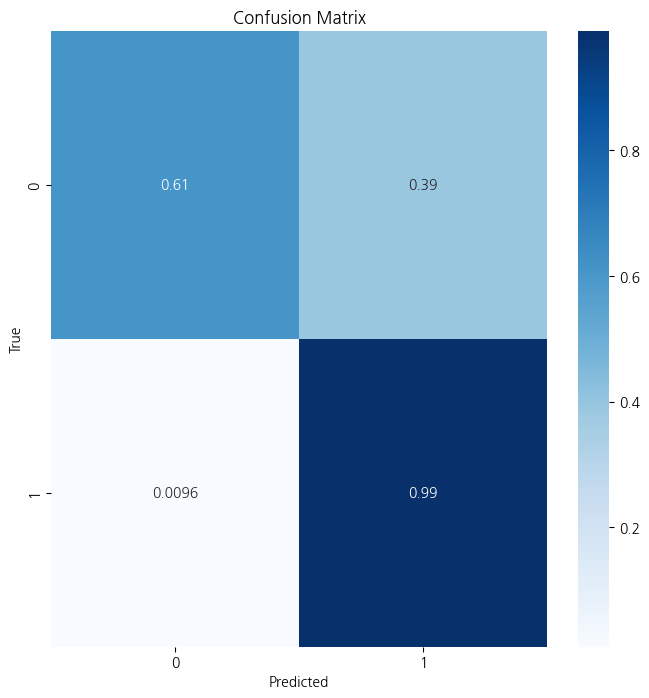

In [126]:
# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred, labels = None, sample_weight = None, normalize = 'true')

# 혼동 행렬 시각화
plt.figure(figsize = (8, 8))
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues')

# tittle 설정
plt.title('Confusion Matrix')

# x축 라벨 설정
plt.xlabel('Predicted')

# y축 라벨 설정
plt.ylabel('True')

plt.show()

##### ROC 곡선 분석 :
- `AUC(Area Under the Curve)`:
    - ROC 곡선 아래의 면적을 나타내며, 모델의 분류 성능을 한눈에 보여주는 지표
    - AUC 값이 1에 가까울수록 모델이 좋은 성능
    - 0.5 이하일 경우 모델이 오히려 잘못된 예측을 하는 모델


##### ROC 곡선 종합 평가 :
- AUC 값이 0.80030이므로 모델델의 분류 성능이 좋음을 나타낸다. 모델이 긍정 클래스와 부정 클래스를 비교적 정확하게 구분하고 있음을 의미한다.

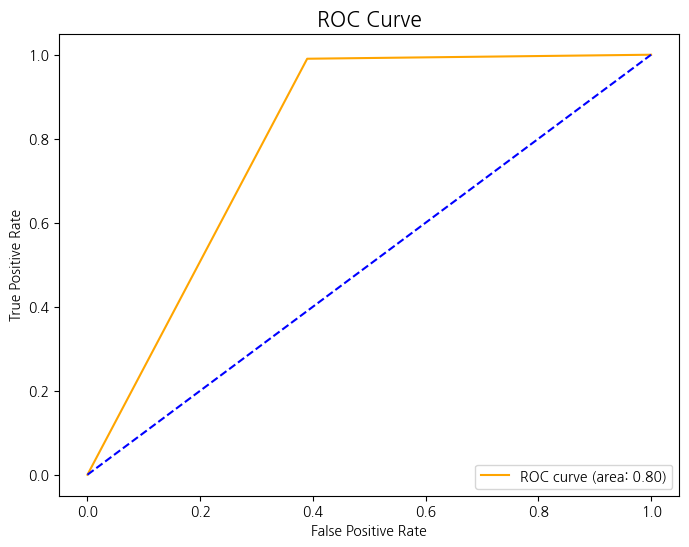

In [128]:
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# ROC 곡선 아래 면적 계산
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

# x축은 fpr, y축은 tpr인 그래프 생성, 라벨로 roc_auc (면적의 넓이) 표시
plt.plot(fpr, tpr, color="orange", label=f"ROC curve (area: {roc_auc:.2f})")

# 기준선 출력 (y=x 그래프)
plt.plot([0, 1], [0, 1], color="blue", linestyle="--") 

# tittle 설정
plt.title('ROC Curve', fontsize=15)

# 범례 설정
plt.legend(loc='lower right')

# x축 라벨 설정
plt.xlabel("False Positive Rate")

# y축 라벨 설정
plt.ylabel("True Positive Rate")

plt.show()

### 7. 마무리
---
- `amazon_uk_shoes_products_dataset_2021_12` 리뷰 데이터를 활용하여 감성 분석을 진행하였습니다. 그 과정에서 데이터 전처리(중복 데이터 제거, 주요 특성 설정, 결측치 확인 및 제거, 노이즈 제거, 토큰화, 불용어 제거, 표제어 추출) 작업이 진행되었고 NLTK의 VADER 감성 분석 모델을 활용하여 감성 분석을 진행하였습니다.

- 그리드 서치 기법을 활용하여 최적의 하이퍼파라미터를 찾아 로지스틱 회귀 모델 학습을 진행하였습니다.
이 모델은 긍정적인 리뷰를 탐지하는 데 매우 정확하지만, 부정적인 리뷰를 식별하는 데는 상대적으로 약한 성능을 보입니다. 만약 이 모델이 긍정적인 리뷰를 정확하게 식별하는 것이 중요한 모델이라면 매우 유용할 것이지만 부정적인 리뷰를 정확히 식별하는 것이 중요한 경우라면 부적합한 모델이 될 것입니다. 이는 모델 학습에 사용한 데이터가 부정적인 리뷰 데이터가 부족했던 원인이 크다고 생각되며 데이터 전처리 과정에서 영어가 아닌 단어를 영어를 판독하여 compound 점수가 낮게 나온 점도 작용하였다고 생각합니다.